Guillermo Trefogli

Earnest Salgado

Antonia Sanhueza

# Final Project: Predicting Dehli mean temperature 

In this project, we will explore the relationship between mean temperature and time. We hypothesize that it is possible to fit a model using historical temperature levels to predict future mean temperature. In this case, we will use a dataset for the city of Delhi, India. We plan to build ARIMA and machine learning models and conduct a comparative analysis to show the predictive performance of models. Finally, we will select our preferable model. Our work will show secondary outputs that are part of the model identification process: data preparation, model fitting, evaluation of models, and selection of the model with the best prediction power.


In [1]:
! pip install sktime
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go

## Exploratory Data Analysis

In [4]:
train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
df = train.append(test)

In [5]:
df.dtypes

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

In [6]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
print('Start date:', df.date.min())
print('End date:', df.date.max())
print('Number of days in training set:', df.date.max() - df.date.min())
train.agg(
    {
        
        "meantemp": ["min", "max", "median", "mean", "std"],
        "humidity": ["min", "max", "median", "mean", "std"],
        "wind_speed": ["min", "max", "median", "mean", "std"],
        "meanpressure": ["min", "max", "median", "mean", "std"],
    }
)

Start date: 2013-01-01 00:00:00
End date: 2017-04-24 00:00:00
Number of days in training set: 1574 days 00:00:00


,meantemp,humidity,wind_speed,meanpressure
min,6.000000,13.428571,0.000000,-3.041667
max,38.714286,100.000000,42.220000,7679.333333
median,27.714286,62.625000,6.221667,1008.563492
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668


In [8]:
df.set_index('date', inplace=True)

fig = px.line(df, x=df.index, y='meantemp')
fig.update_layout(title='Dehli daily mean temperature 2013 - 2017')
fig.show()

In [9]:
fig = px.line(df, x=df.index, y='humidity')
fig.update_layout(title='Dehli daily humidity 2013 - 2017')
fig.show()

In [10]:
fig = px.line(df, x=df.index, y='wind_speed')
fig.update_layout(title='Dehli daily wind speed 2013 - 2017')
fig.show()

In [11]:
fig = px.scatter(df, x=df.index, y='meanpressure')
fig.update_layout(title='Dehli daily mean pressure 2013 - 2017')
fig.show()

In [12]:
df.corr()

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.574849,0.288088,-0.034681
humidity,-0.574849,1.000000,-0.373602,-0.001672
wind_speed,0.288088,-0.373602,1.000000,-0.016949
meanpressure,-0.034681,-0.001672,-0.016949,1.000000


## Initial modelling

As we saw, there is clear yearly seasonality with peaks during the summer, and lows during the winter.

For our initial model we will only use the mean temperature and its lags.

In [13]:
y_train, y_test = temporal_train_test_split(df)

y_train['diff1_temp'] = y_train.meantemp.diff()
y_train['diff12_temp'] = y_train.meantemp.diff(periods=12)

y_train.dropna(inplace=True)
fig = px.line(y_train, x=y_train.index,
              y=['diff1_temp', 'diff12_temp'])

fig.show()

In [14]:
# Some of the code was copied. from class notebook
def adf_kpss_test(df_col, alpha, reg='c'):
    '''
    Return tuple of booleans indicating if
    ADF and KPSS were passed
    Input:
    - df_col: dataframe column
    - alpha: level of confidence for test
    Output:
    adf, kpss: tuple of booleans
    '''
    adf_results = adfuller(df_col)
    adf_pval = adf_results[1]
    adf_bool = adf_pval <= alpha

    kpss_results = kpss(df_col, regression=reg)
    kpss_pval = kpss_results[1]
    kpss_bool = kpss_pval >= alpha
    
    return adf_bool, adf_pval, kpss_bool, kpss_pval

In [15]:
alpha = 0.05
for col in ['meantemp', 'diff1_temp', 'diff12_temp']:
    adf_bool, adf_pval, kpss_bool, kpss_pval = adf_kpss_test(y_train[3:][col], alpha)
    print(col)
    print('\t - ADF pval', adf_pval)
    print('\t - ADF Stationarity test:', adf_bool)
    print('\t - KPSS pval', kpss_pval)
    print('\t - KPSS Stationarity test:', kpss_bool)

meantemp
	 - ADF pval 0.19819498694447923
	 - ADF Stationarity test: False
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
diff1_temp
	 - ADF pval 1.3944444323255702e-26
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
diff12_temp
	 - ADF pval 4.496300487316425e-08
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




We can see the mean temperature series is not stationary, but difference stationary. The differenced data and the yearly seasonal difference is.

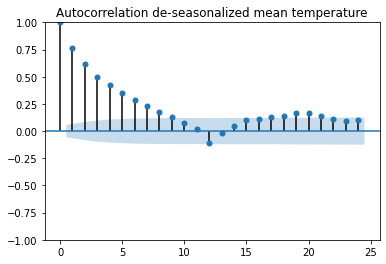

In [16]:
# ACF
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(y_train['diff12_temp'].dropna(), lags = 24)
plt.title('Autocorrelation de-seasonalized mean temperature')
plt.show()

Since there is no exponential drop, then we can't identify a MA behaviour. Hence, q=0.

In the seasonal component, we can see a barely significant lag in 12, hence Q = 1.

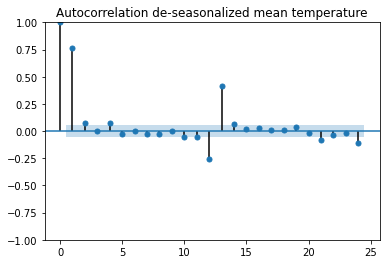

In [17]:
plot_pacf(y_train['diff12_temp'].dropna(), lags = 24)
plt.title('Autocorrelation de-seasonalized mean temperature')
plt.show()

We can see significant lags in 12 and 24, hence we will have an AR(2) probably (P = 2). This is the seasonal difference D=1, m= 12.

For the non seasonal component we can see that the first lag is significant. Hence, p = 10.

In [18]:
from statsmodels.tsa.statespace import sarimax

sarima_model = sarimax.SARIMAX(endog=y_train['meantemp'].dropna(),order=(9,0,0), seasonal_order=(2, 1, 1, 12))
sarima_fit = sarima_model.fit()
print('SARIMA temp')
print(sarima_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



SARIMA temp
                                      SARIMAX Results                                       
Dep. Variable:                             meantemp   No. Observations:                 1170
Model:             SARIMAX(9, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -2208.779
Date:                              Sat, 28 May 2022   AIC                           4443.559
Time:                                      06:51:59   BIC                           4509.267
Sample:                                  01-13-2013   HQIC                          4468.354
                                       - 03-27-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7864      0.025     31.123      0.000       0.737       0.836
ar.L2  

In [19]:
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (9, 0, 0)(2, 1, 1, 12): 4443.877116543679


The AIC is kind of high. Let's try AutoArima to see if we find a better fit model.

In [ ]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(y_train['meantemp'],
                      test='adf',
                      max_p=3, max_q=3,
                      D=1,
                      m=12,
                      seasonal=True,
                      max_P = 3, max_Q = 3,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
auto_arima_fit = auto_arima_model.fit(y_train['meantemp'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=29.08 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6118.907, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4830.848, Time=2.52 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=5466.496, Time=1.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6118.763, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5105.902, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4719.080, Time=4.98 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=4668.147, Time=12.52 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=53.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=25.14 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=6003.257, Time=7.77 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=4654.238, Time=15.24 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4707.898, Time=5.94 sec
 ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=48.27 sec
 ARIMA(2,0,0)(2,1,1)[12] intercep

**the RAM runs out on colab but this is the best model order Best model:  ARIMA(2,0,1)(3,1,0)[12]**

In [37]:
auto_arima_model = sarimax.SARIMAX(endog=y_train['meantemp'].dropna(),order=(9,0,1), seasonal_order=(3, 1, 0, 12))
auto_arima_fit = auto_arima_model.fit()
print("AICc for order " + str(auto_arima_model.order) + str(auto_arima_model.seasonal_order) +": " +str(auto_arima_fit.aicc))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AICc for order (9, 0, 1)(3, 1, 0, 12): 4607.010302643675


In [38]:
print(auto_arima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                 1170
Model:             SARIMAX(9, 0, 1)x(3, 1, [], 12)   Log Likelihood               -2289.321
Date:                             Sat, 28 May 2022   AIC                           4606.643
Time:                                     06:56:08   BIC                           4677.405
Sample:                                 01-13-2013   HQIC                          4633.345
                                      - 03-27-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2028      0.027     -7.467      0.000      -0.256      -0.150
ar.L2          0.7926      

We can see that our model has a better AIC than the autoarima selection. 

**Examining our SARIMA residuals**

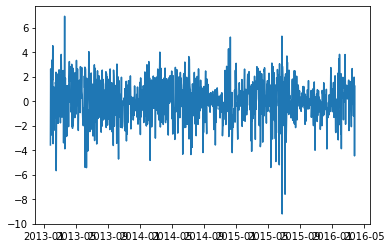

In [39]:
resid = sarima_fit.resid
resid = resid[12:]
plt.plot(resid)

(array([  2.,   0.,  10.,  44., 182., 453., 360.,  97.,   9.,   1.]),
 array([-9.21216453, -7.59875251, -5.98534049, -4.37192847, -2.75851645,
        -1.14510443,  0.46830758,  2.0817196 ,  3.69513162,  5.30854364,
         6.92195566]),
 <a list of 10 Patch objects>)

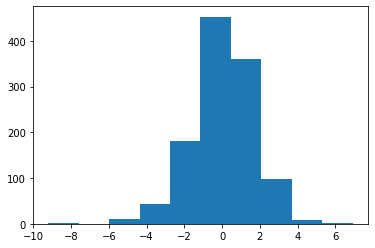

In [40]:
plt.hist(resid)

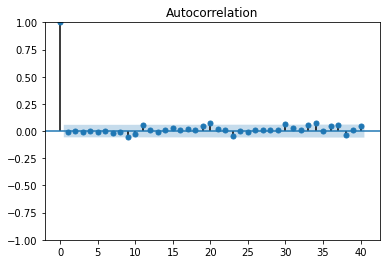

In [41]:
plot_acf(resid, lags=40)
plt.show()

We see that there are 2 significant lag residuals.

In [42]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,5.942066,0.820107,5.887242,0.824646


From the pvalues we can see we reject the null hypothesis at the 95% confidence level. Hence, Ljung box and Box Pierce shows we reject the null that the model doesn't show a lack of fit. Let's see if autoarima orders fix this issue.



**Examining auto arima residuals**

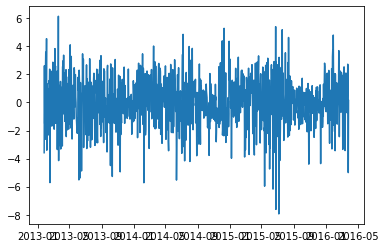

In [43]:
resid = auto_arima_fit.resid
resid = resid[12:]
plt.plot(resid)

(array([  2.,   8.,  17.,  70., 234., 365., 312., 126.,  18.,   6.]),
 array([-7.94640585, -6.53723993, -5.12807401, -3.71890809, -2.30974217,
        -0.90057625,  0.50858967,  1.91775559,  3.32692151,  4.73608743,
         6.14525335]),
 <a list of 10 Patch objects>)

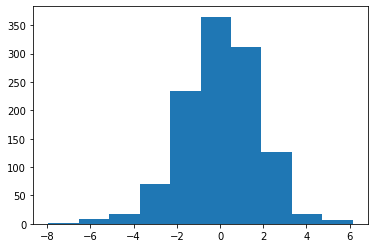

In [44]:
plt.hist(resid)

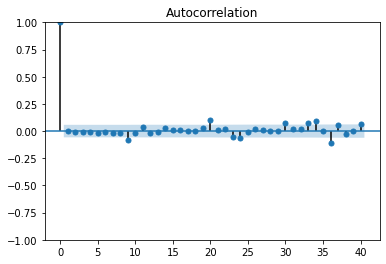

In [45]:
plot_acf(resid, lags=40)
plt.show()

ACF doesn't show significant lags residuals.

In [46]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,9.898825,0.449414,9.807647,0.457528


From the pvalues we can see we don't reject the null hypothesis at the 95% confidence level. Hence, Ljung box and Box Pierce shows we don't reject the null that the model doesn't show a lack of fit, i.e the model is fine, the errors don't show presence of autocorrelation

**Predictions**

In [47]:
import numpy as np
#smape code: https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python
def smape(A, F):
  return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [48]:
y_pred = auto_arima_fit.forecast(steps=len(y_test))

In [49]:
px.line(y_pred)
px.line(y_test['meantemp'])

fig = go.Figure()

fig.add_trace(go.Line(
    x=y_test.index,
    y=y_test['meantemp'],
    name="True values"       # this sets its legend entry
))


fig.add_trace(go.Line(
    x=y_pred.index,
    y=y_pred,
    name="Predicted values"
))

fig.update_layout(title='Seasonal ARIMA predictions',
           xaxis_title='date',
           yaxis_title='Mean temperature',
           )


fig.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

mae =  mean_absolute_error(y_pred, y_test['meantemp'])
mse = mean_squared_error(y_pred, y_test['meantemp'])
rmse = np.sqrt(mean_squared_error(y_pred, y_test['meantemp']))
mape = mean_absolute_percentage_error(y_pred, y_test['meantemp'])
smape = smape(np.array(y_pred), np.array(y_test['meantemp']))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_test['meantemp'], y_train=y_train['meantemp'])

print('Auto Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Auto Arima errors
MAE: 9.647796191956935
MSE: 145.27793129190994
RMSE: 12.05312952273848
MAPE: 0.2636163654508824
SMAPE: 33.042573431241514
MASE: 7.90203368808006


## Prophet

In [ ]:
! pip install pystan --user
! pip install fbprophet --user
! pip install wbdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from util_prophet import *
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [ ]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'meantemp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'meantemp':'y'}, inplace=True)

In [ ]:
y_train_prophet

,y,humidity,wind_speed,meanpressure,diff1_temp,diff12_temp,ds,diff1_humidity,diff1_wind_speed,diff12_humidity,diff12_wind_speed,diff1_pressure,diff12_pressure
2013-01-25,12.250000,67.000000,5.550000,1020.750000,-1.583333,-3.583333,2013-01-25,0.250000,-0.616667,7.416667,0.916667,0.250000,7.416667
2013-01-26,12.666667,64.166667,6.800000,1019.666667,0.416667,-0.166667,2013-01-26,-1.083333,1.250000,4.500000,6.183333,-1.083333,4.500000
2013-01-27,12.857143,65.571429,5.557143,1018.142857,0.190476,-1.857143,2013-01-27,-1.523810,-1.242857,2.285714,5.028571,-1.523810,2.285714
2013-01-28,14.833333,56.000000,3.700000,1017.833333,1.976190,1.000000,2013-01-28,-0.309524,-1.857143,1.166667,3.700000,-0.309524,1.166667
2013-01-29,14.125000,65.500000,3.237500,1016.625000,-0.708333,-2.375000,2013-01-29,-1.208333,-0.462500,0.791667,-2.012500,-1.208333,0.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-23,26.200000,43.266667,10.641667,1010.000000,1.137500,1.133333,2016-03-23,0.625000,-11.458333,-2.533333,4.095000,0.625000,-2.533333
2016-03-24,28.133333,46.866667,3.213333,1013.333333,1.933333,3.570833,2016-03-24,3.333333,-7.428333,3.770833,-6.274167,3.333333,3.770833
2016-03-25,29.875000,50.187500,3.368750,1013.187500,1.741667,5.625000,2016-03-25,-0.145833,0.155417,2.000000,-3.475000,-0.145833,2.000000
2016-03-26,24.666667,62.666667,9.393333,1013.600000,-5.208333,2.291667,2016-03-26,0.412500,6.024583,-0.712500,3.118333,0.412500,-0.712500


In [ ]:
model = Prophet()
model.fit(y_train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_data = model.make_future_dataframe(periods=len(y_test))

In [ ]:
future_data

,ds
0,2013-01-25
1,2013-01-26
2,2013-01-27
3,2013-01-28
4,2013-01-29
...,...
1547,2017-04-21
1548,2017-04-22
1549,2017-04-23
1550,2017-04-24


In [ ]:
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

,0,1,2
ds,2013-01-25 00:00:00,2013-01-26 00:00:00,2013-01-27 00:00:00
trend,25.056492,25.055184,25.053875
yhat_lower,11.115215,11.225566,11.190286
yhat_upper,16.377682,16.236993,16.161546
trend_lower,25.056492,25.055184,25.053875
trend_upper,25.056492,25.055184,25.053875
additive_terms,-11.325226,-11.297304,-11.361617
additive_terms_lower,-11.325226,-11.297304,-11.361617
additive_terms_upper,-11.325226,-11.297304,-11.361617
weekly,-0.032893,-0.088188,-0.24731


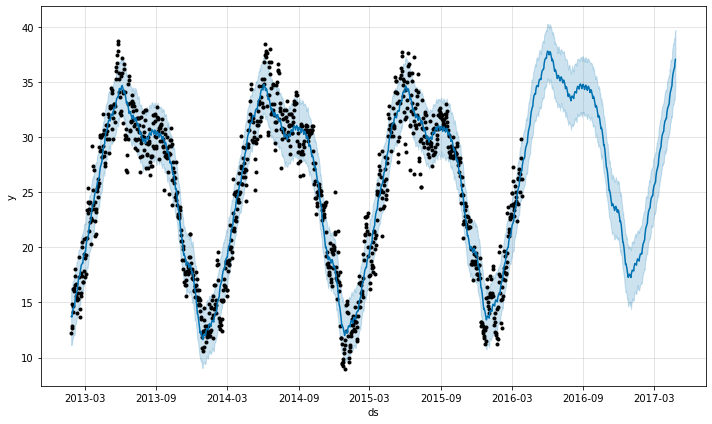

In [ ]:
p = model.plot(forecast_data)

In [ ]:
y_pred_prophet = forecast_data[-len(y_test):-1]['yhat']
y_test_prophet = y_test['y']


fig = go.Figure()

fig.add_trace(go.Line(
    x=y_test.index,
    y=y_test_prophet ,
    name="True values"       # this sets its legend entry
))


fig.add_trace(go.Line(
    x=y_test.index,
    y=y_pred_prophet,
    name="Predicted values"
))

fig.update_layout(title='Prophet predictions',
           xaxis_title='date',
           yaxis_title='Mean temperature',
           )


fig.show()

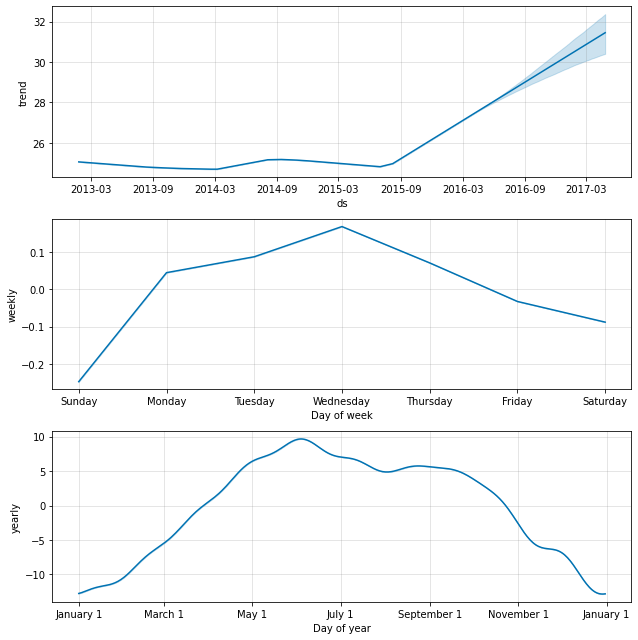

In [ ]:
model.plot_components(forecast_data)
plt.savefig('decomposition.png')

In [ ]:
ind = forecast_data[forecast_data ['ds'] == y_test.index[0]].index[0]
y_pred = forecast_data[ind:]['yhat']
y_true = y_test['y']

In [ ]:
mae =  mean_absolute_error(y_pred, y_true)
mse = mean_squared_error(y_pred, y_true)
rmse = np.sqrt(mean_squared_error(y_pred, y_true))
mape = mean_absolute_percentage_error(y_pred, y_true)
smape = smape(np.array(y_pred), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

Seasonal Arima errors
MAE: 2.8154210410855285
MSE: 12.230826142176815
RMSE: 3.4972598047867156
MAPE: 0.10137800255261725
SMAPE: 11.037425616955169
MASE: 2.2946740477370207


## Granger causality

In [ ]:
# 1. Difference the data
df['diff_meantemp'] = df.meantemp.diff()
df['diff_humidity'] = df.humidity.diff()
df['diff_wind_speed'] = df.wind_speed.diff()
df['diff_meanpressure'] = df.meanpressure.diff()

df.dropna(inplace=True)

In [ ]:
def plot_Granger(granger_results, alpha=0.05):
    res_list = []
    for lag, v in granger_results.items():
        res = {}
        res['Lag'] = lag
        for test, stats in v[0].items():
            res[test] = stats[1]

        res_list.append(res)

    pvals = pd.DataFrame(res_list)
    pvals.set_index('Lag', inplace=True)
    pvals_graph = pvals['params_ftest']

    pvals_graph.plot(title='Granger Causality Test')
    alpha_ser = pd.Series([alpha]*len(pvals_graph), index=pvals_graph.index)
    alpha_ser.plot(color='red')
    plt.ylabel('p-value')
    plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.8425 , p=0.0000  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=29.8994 , p=0.0000  , df=1
likelihood ratio test: chi2=29.6190 , p=0.0000  , df=1
parameter F test:         F=29.8425 , p=0.0000  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6691  , p=0.0257  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=7.3616  , p=0.0252  , df=2
likelihood ratio test: chi2=7.3444  , p=0.0254  , df=2
parameter F test:         F=3.6691  , p=0.0257  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1922  , p=0.0014  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=15.6464 , p=0.0013  , df=3
likelihood ratio test: chi2=15.5690 , p=0.0014  , df=3
parameter F test:         F=5.1922  , p=0.0014  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2214  , p=0.

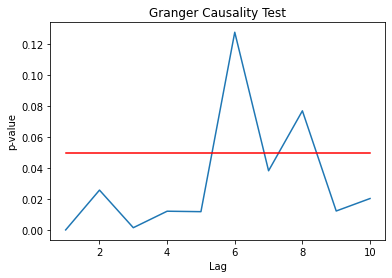


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4060 , p=0.0004  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=12.4297 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3809 , p=0.0004  , df=1
parameter F test:         F=12.4060 , p=0.0004  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4835  , p=0.0002  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=17.0211 , p=0.0002  , df=2
likelihood ratio test: chi2=16.9297 , p=0.0002  , df=2
parameter F test:         F=8.4835  , p=0.0002  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0900  , p=0.0017  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=15.3383 , p=0.0015  , df=3
likelihood ratio test: chi2=15.2640 , p=0.0016  , df=3
parameter F test:         F=5.0900  , p=0.0017  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7133  , p=0.

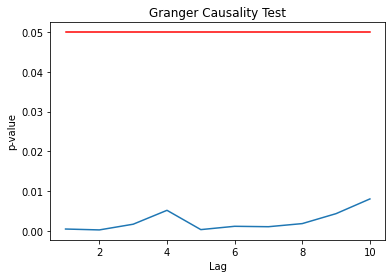


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7211  , p=0.3959  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=0.7225  , p=0.3953  , df=1
likelihood ratio test: chi2=0.7224  , p=0.3954  , df=1
parameter F test:         F=0.7211  , p=0.3959  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6778  , p=0.5079  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=1.3600  , p=0.5066  , df=2
likelihood ratio test: chi2=1.3594  , p=0.5068  , df=2
parameter F test:         F=0.6778  , p=0.5079  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3864  , p=0.7628  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=1.1645  , p=0.7615  , df=3
likelihood ratio test: chi2=1.1641  , p=0.7616  , df=3
parameter F test:         F=0.3864  , p=0.7628  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5154  , p=0.

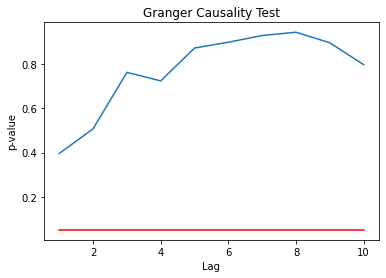

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests, q_stat

for col in ['diff_humidity', 'diff_wind_speed', 'diff_meanpressure']:
    data = df[['meantemp', col ]].dropna()
    granger_results = grangercausalitytests(data, maxlag=10, verbose=True)
    print(col)
    plot_Granger(granger_results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.0276 , p=0.0005  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=12.0506 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0047 , p=0.0005  , df=1
parameter F test:         F=12.0276 , p=0.0005  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.1220 , p=0.0000  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=48.3979 , p=0.0000  , df=2
likelihood ratio test: chi2=47.6683 , p=0.0000  , df=2
parameter F test:         F=24.1220 , p=0.0000  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.1011 , p=0.0000  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=42.4924 , p=0.0000  , df=3
likelihood ratio test: chi2=41.9282 , p=0.0000  , df=3
parameter F test:         F=14.1011 , p=0.0000  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.0910 , p=0.

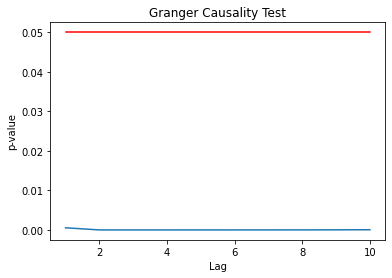


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1278  , p=0.7208  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=0.1280  , p=0.7205  , df=1
likelihood ratio test: chi2=0.1280  , p=0.7205  , df=1
parameter F test:         F=0.1278  , p=0.7208  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5189  , p=0.0809  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=5.0539  , p=0.0799  , df=2
likelihood ratio test: chi2=5.0458  , p=0.0802  , df=2
parameter F test:         F=2.5189  , p=0.0809  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8446  , p=0.0093  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=11.5853 , p=0.0089  , df=3
likelihood ratio test: chi2=11.5428 , p=0.0091  , df=3
parameter F test:         F=3.8446  , p=0.0093  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9181  , p=0.

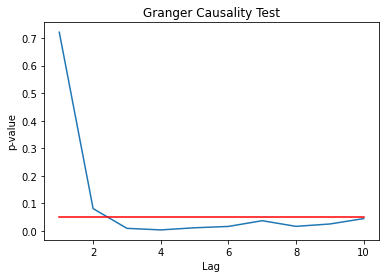


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0037  , p=0.9516  , df_denom=1571, df_num=1
ssr based chi2 test:   chi2=0.0037  , p=0.9516  , df=1
likelihood ratio test: chi2=0.0037  , p=0.9516  , df=1
parameter F test:         F=0.0037  , p=0.9516  , df_denom=1571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1119  , p=0.8941  , df_denom=1568, df_num=2
ssr based chi2 test:   chi2=0.2246  , p=0.8938  , df=2
likelihood ratio test: chi2=0.2245  , p=0.8938  , df=2
parameter F test:         F=0.1119  , p=0.8941  , df_denom=1568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2711  , p=0.0052  , df_denom=1565, df_num=3
ssr based chi2 test:   chi2=12.8707 , p=0.0049  , df=3
likelihood ratio test: chi2=12.8183 , p=0.0050  , df=3
parameter F test:         F=4.2711  , p=0.0052  , df_denom=1565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1499  , p=0.

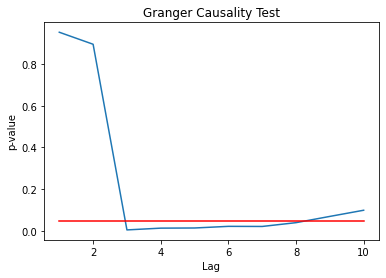

In [ ]:
for col in ['diff_humidity', 'diff_wind_speed', 'diff_meanpressure']:
    data = df[[col, 'meantemp']].dropna()
    granger_results = grangercausalitytests(data, maxlag=10, verbose=True)
    print(col)
    plot_Granger(granger_results)

From here we conclude that wind_speed and humidity lags are good predictors for mean temperature.

## VAR/VARMA

We know the first difference of temperature is stationary but what about the other series?

In [ ]:
y_train
y_train['diff1_humidity'] = y_train.humidity.diff()
y_train['diff12_humidity'] = y_train.humidity.diff(12)
y_train['diff1_wind_speed'] = y_train.wind_speed.diff()
y_train['diff12_wind_speed'] = y_train.wind_speed.diff(12)
y_train['diff1_pressure'] = y_train.meanpressure.diff()
y_train['diff12_pressure'] = y_train.meanpressure.diff(12)

y_train.dropna(inplace=True)
for col in ['humidity', 'diff1_humidity', 'diff12_humidity',
            'wind_speed', 'diff1_wind_speed', 'diff12_wind_speed',
            'meanpressure', 'diff1_pressure', 'diff12_pressure']:
    adf_bool, adf_pval, kpss_bool, kpss_pval = adf_kpss_test(y_train[col], alpha)
    print(col)
    print('\t - ADF pval', adf_pval)
    print('\t - ADF Stationarity test:', adf_bool)
    print('\t - KPSS pval', kpss_pval)
    print('\t - KPSS Stationarity test:', kpss_bool)

humidity
	 - ADF pval 0.003131139659161032
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
diff1_humidity
	 - ADF pval 1.884600851674913e-19
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
diff12_humidity
	 - ADF pval 2.0021655876896837e-14
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
wind_speed
	 - ADF pval 0.013353527353525449
	 - ADF Stationarity test: True
	 - KPSS pval 0.021214797904009677
	 - KPSS Stationarity test: False
diff1_wind_speed
	 - ADF pval 8.176408246158348e-25
	 - ADF Stationarity test: True
	 - KPSS pval 0.04166666666669265
	 - KPSS Stationarity test: False
diff12_wind_speed
	 - ADF pval 1.0326509732457596e-21
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True
meanpressure
	 - ADF pval 0.28929995301841993
	 - ADF Stationarity test: False
	 - KPSS pval 0.08520350410462997
	 - KPSS Stationarity test: True
diff1_pressure
	 - ADF pv

We see that humidity is already a stationary series, and that the wind and pressure are difference stationary so we can use the first difference for our VAR - VARMA models.

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [ ]:
# VARMAX automatically enforces stationarity
varma_df = y_train[['y','humidity', 'wind_speed']].dropna()
train = varma_df[:-13]
test = varma_df[-13:]

var_df = y_train[['diff1_temp','diff1_wind_speed', 'diff1_humidity', 'diff1_pressure']].dropna()
train_var = var_df[:-12]
test_var = var_df[-12:]

In [ ]:
prange = range(0,4)
qrange = range(1,4)

max_aic = np.inf
best_order = None

In [ ]:
# VARMAX automatically enforces stationarity

print('Running search of VARMA')
for p in prange:
    for q in qrange:
        order = (p, q)
        varma_model = VARMAX(train, order=order).fit(disp=False)
        current_aic = varma_model.aic
        print('\t Order is', order, 'with AIC of', current_aic)
        if current_aic < max_aic:
            max_aic = current_aic 
            best_order = order

print('Best VARMA order is', best_order, 'with AIC of', max_aic)

max_aic_var = np.inf
best_order_var = None
print('Running search of VAR')
for p in prange:
    order = (p, 0)
    var_model = VAR(train).fit(p)
    current_aic = var_model.aic
    print('\t Order is', order, 'with AIC of', current_aic)
    if current_aic < max_aic_var:
        max_aic_var = current_aic 
        best_order_var = order

print('Best VAR order is', best_order_var, 'with AIC of', max_aic_var)

Running search of VARMA
	 Order is (0, 1) with AIC of 21388.96877063709
	 Order is (0, 2) with AIC of 20655.454950455656
	 Order is (0, 3) with AIC of 20451.650758399963
	 Order is (1, 1) with AIC of 18222.79358199804
	 Order is (1, 2) with AIC of 18208.151516105885
	 Order is (1, 3) with AIC of 18180.16640189612
	 Order is (2, 1) with AIC of 18234.048101750042
	 Order is (2, 2) with AIC of 18192.391300329247
	 Order is (2, 3) with AIC of 18178.757584399093
	 Order is (3, 1) with AIC of 18196.674228487518
	 Order is (3, 2) with AIC of 18193.080673778386
	 Order is (3, 3) with AIC of 18177.428894335695
Best VARMA order is (3, 3) with AIC of 18177.428894335695
Running search of VAR
	 Order is (0, 0) with AIC of 12.077395515560395
	 Order is (1, 0) with AIC of 7.421199479385142
	 Order is (2, 0) with AIC of 7.398940423600766
	 Order is (3, 0) with AIC of 7.370662299337992
Best VAR order is (3, 0) with AIC of 7.370662299337992


We can see that the AIC of the VAR model is extremely low, our best so far in fact. We would expect the predictions with this model to have the lowest errors.

In [ ]:
var_model = VAR(train_var).fit(3)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, May, 2022
Time:                     21:48:49
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    8.54632
Nobs:                     1131.00    HQIC:                   8.40240
Log likelihood:          -11069.4    FPE:                    4084.77
AIC:                      8.31502    Det(Omega_mle):         3902.24
--------------------------------------------------------------------
Results for equation diff1_temp
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.011762         0.047682            0.247           0.805
L1.diff1_temp              -0.161046         0.040328           -3.993           0.000
L1.diff1_wind_speed        -0.0

Correlation matrix close to 0 outside diagonal

In [ ]:
var_model.test_whiteness(signif =0.01).summary()

Test statistic,Critical value,p-value,df
255.0,149.7,0.000,112


We see autocorrelation of the lags

In [ ]:
yhat = var_model.forecast(var_model.endog, steps=12)
idx=test_var.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.rename(columns={0:'y', 1:'humidity', 2:'wind_speed', 3:'meanpressure'}, inplace=True)
df_preds

,y,humidity,wind_speed,meanpressure
2016-03-16,0.046325,-1.026326,1.673905,-0.957532
2016-03-17,0.177613,-0.589505,0.989149,-0.721428
2016-03-18,-0.172507,0.495897,0.533643,0.079727
2016-03-19,-0.039118,0.321336,-0.427508,0.346715
2016-03-20,-0.041550,-0.128846,-0.172407,0.109825
2016-03-21,0.042589,-0.202005,-0.090380,-0.108922
2016-03-22,0.041668,0.022129,0.042539,-0.090418
2016-03-23,0.016131,0.060599,0.058325,0.006343
2016-03-24,-0.008465,0.019956,0.030315,0.035473
2016-03-25,-0.001694,-0.015893,-0.039253,0.006800


In [ ]:
forecast_results1

,y_forecast,humidity_forecast,wind_speed_forecast,meanpressure_forecast
2016-03-16,24.112992,57.907007,10.320572,1013.909135
2016-03-17,24.290605,57.317502,11.309721,1013.187706
2016-03-18,24.118098,57.813399,11.843364,1013.267433
2016-03-19,24.078980,58.134735,11.415855,1013.614148
2016-03-20,24.037429,58.005889,11.243448,1013.723973
2016-03-21,24.080019,57.803884,11.153068,1013.615051
2016-03-22,24.121687,57.826013,11.195607,1013.524633
2016-03-23,24.137818,57.886612,11.253933,1013.530975
2016-03-24,24.129353,57.906569,11.284248,1013.566448
2016-03-25,24.127659,57.890676,11.244995,1013.573248


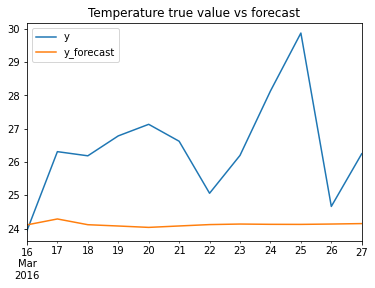

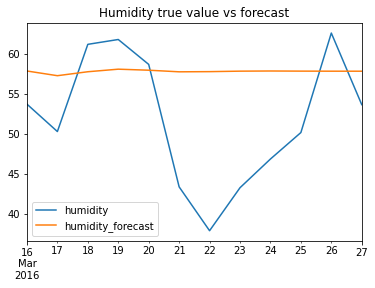

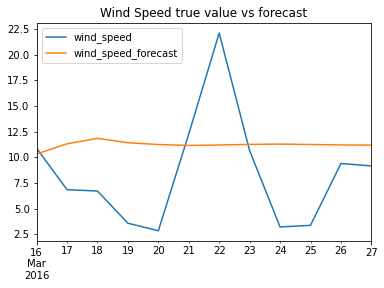

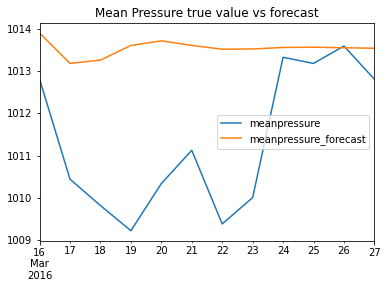

In [ ]:
# forecast_results1 = pd.concat([df[df.index==train_var.index[-1]], 
#                                df_preds[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]], axis=0).reset_index(drop=True)\
#                     .cumsum()\
#                     .drop([0])\
#                     .set_index(idx) 

forecast_results1 = pd.concat([y_train[-13:-12][['y', 'humidity', 'wind_speed', 'meanpressure']], 
                               df_preds[['y', 'humidity', 'wind_speed', 'meanpressure']]], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx) 

forecast_results1.columns = ['y_forecast', 'humidity_forecast', 'wind_speed_forecast', 'meanpressure_forecast']

forecast_t = pd.concat([y_train[-12:]['y'],forecast_results1[['y_forecast']]], axis=1)
forecast_t.plot()
plt.title('Temperature true value vs forecast')
plt.show()

forecast_h = pd.concat([y_train[-12:]['humidity'],forecast_results1[['humidity_forecast']]], axis=1)
forecast_h.plot()
plt.title('Humidity true value vs forecast')
plt.show()


forecast_w = pd.concat([y_train[-12:]['wind_speed'],forecast_results1[['wind_speed_forecast']]], axis=1)
forecast_w.plot()
plt.title('Wind Speed true value vs forecast')
plt.show()

forecast_p = pd.concat([y_train[-12:]['meanpressure'],forecast_results1[['meanpressure_forecast']]], axis=1)
forecast_p.plot()
plt.title('Mean Pressure true value vs forecast')
plt.show()



,y_forecast
2016-03-16,24.112992
2016-03-17,24.290605
2016-03-18,24.118098
2016-03-19,24.078980
2016-03-20,24.037429
2016-03-21,24.080019
2016-03-22,24.121687
2016-03-23,24.137818
2016-03-24,24.129353
2016-03-25,24.127659


In [ ]:

fig = go.Figure()

fig.add_trace(go.Line(
    x=y_train[-12:].index,
    y=y_train[-12:]['y'],
    name="True values"       # this sets its legend entry
))


fig.add_trace(go.Line(
    x=forecast_results1.index,
    y=forecast_results1['y_forecast'],
    name="Predicted values"
))

fig.update_layout(title='VAR predictions',
           xaxis_title='date',
           yaxis_title='Mean temperature',
           )


fig.show()

In [ ]:
mse = mean_squared_error(forecast_t['y'], forecast_t['y_forecast'])
rmse = np.sqrt(mean_squared_error(forecast_t['y'], forecast_t['y_forecast']))
print(mse)
print(rmse)

7.556148816299603
2.7488449967758464


In [ ]:
yhat_test = var_model.forecast(var_model.endog, steps=len(y_test))
yhat_test

# Random Forest

### Time Series Data Preparation

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from math import sqrt

In [ ]:
# load dataset
train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
df = train.append(test)
df.set_index('date', inplace=True)

In [ ]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [ ]:
df_lags = df.shift().rename(columns = {'meantemp':'meantemp_lag1', 
                             'humidity':'humidity_lag1',
                             'wind_speed':'wind_speed_lag1',
                             'meanpressure':'meanpressure_lag1'
                            })

In [ ]:
df_lags = df.join(df_lags).dropna()
df_lags

,meantemp,humidity,wind_speed,meanpressure,meantemp_lag1,humidity_lag1,wind_speed_lag1,meanpressure_lag1
date,,,,,,,,
2013-01-02,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000,33.500000,24.125000,9.025000,1000.875000
2017-04-21,34.250000,39.375000,6.962500,999.875000,34.500000,27.500000,5.562500,998.625000
2017-04-22,32.900000,40.900000,8.890000,1001.600000,34.250000,39.375000,6.962500,999.875000


In [ ]:
train, test = temporal_train_test_split(df_lags)

print(train.shape)
print(test.shape)

(1182, 8)
(395, 8)


In [ ]:
train_x = np.asarray(train.loc[:, train.columns!='meantemp'])
train_y = np.asarray(train['meantemp'])

In [ ]:
test_x = np.asarray(test.loc[:, test.columns!='meantemp'])
test_y = np.asarray(test['meantemp'])

In [ ]:
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(train_x, train_y)

RandomForestRegressor(n_estimators=1000)

In [ ]:
import sklearn.metrics as metrics

y_pred_train = model.predict(train_x)
y_pred_test = model.predict(test_x)

mae_train = metrics.mean_absolute_error(train_y, y_pred_train)
mae_test = metrics.mean_absolute_error(test_y, y_pred_test)

mse_train = metrics.mean_squared_error(train_y, y_pred_train)
rmse_train = np.sqrt(metrics.mean_squared_error(train_y, y_pred_train))
mse_test = metrics.mean_squared_error(test_y, y_pred_test)
rmse_test = np.sqrt(metrics.mean_squared_error(test_y, y_pred_test))

print('MAE train is: ', mae_train)
print('MSE train is: ', mse_train)
print('RMSE train is: ', rmse_train)
print('MAE test is: ', mae_test)
print('MSE test is: ', mse_test)
print('RMSE test is: ', rmse_test)

MAE train is:  0.36689420188135036
MSE train is:  0.2361237753711195
RMSE train is:  0.48592568914507855
MAE test is:  1.1939217480981417
MSE test is:  2.3186453801961733
RMSE test is:  1.5227098805078312


In [ ]:
test['y_pred'] = y_pred_test

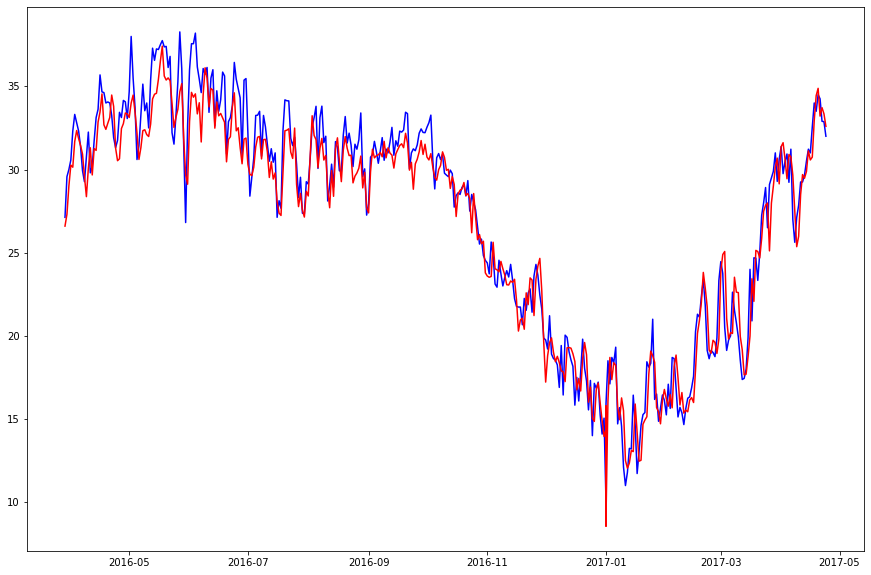

In [ ]:
# plot dataset
# plot
plt.figure(figsize=(15,10))  
plt.plot(test['meantemp'], color='blue')
plt.plot(test['y_pred'], color='red')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Line(
    x=test.index,
    y=test['meantemp'],
    name="True values"       # this sets its legend entry
))


fig.add_trace(go.Line(
    x=test.index,
    y=test['y_pred'],
    name="Predicted values"
))

fig.update_layout(title='Random Forest predictions',
           xaxis_title='date',
           yaxis_title='Mean temperature',
           )


fig.show()

Text(0.5, 1.0, 'Feature importance')

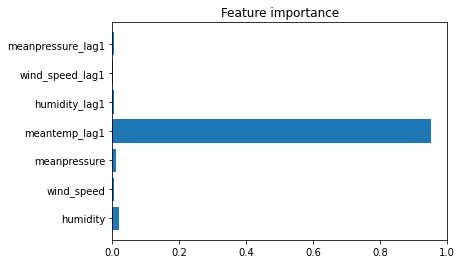

In [ ]:
features = train.columns[1:]
plt.barh(features, model.feature_importances_)
plt.title('Feature importance')


## Time series forest regressor

In [ ]:
from sktime.regression.interval_based import TimeSeriesForestRegressor

# fit model
tsmodel = TimeSeriesForestRegressor(n_estimators=1000)
tsmodel.fit(train_x, train_y)

TimeSeriesForestRegressor(n_estimators=1000)

In [ ]:
y_pred_train = tsmodel.predict(train_x)
y_pred_test = tsmodel.predict(test_x)

mae_train = metrics.mean_absolute_error(train_y, y_pred_train)
mae_test = metrics.mean_absolute_error(test_y, y_pred_test)

mse_train = metrics.mean_squared_error(train_y, y_pred_train)
rmse_train = np.sqrt(metrics.mean_squared_error(train_y, y_pred_train))
mse_test = metrics.mean_squared_error(test_y, y_pred_test)

print('MAE train is: ', mae_train)
print('MSE train is: ', mse_train)
print('RMSE train is: ', rmse_train)
print('MAE test is: ', mae_test)
print('MSE test is: ', mse_test)

MAE train is:  7.719412625567984e-14
MSE train is:  3.1427567753867554e-26
RMSE train is:  1.772782213185465e-13
MAE test is:  1.7495502282204975
MSE test is:  5.627160131210267


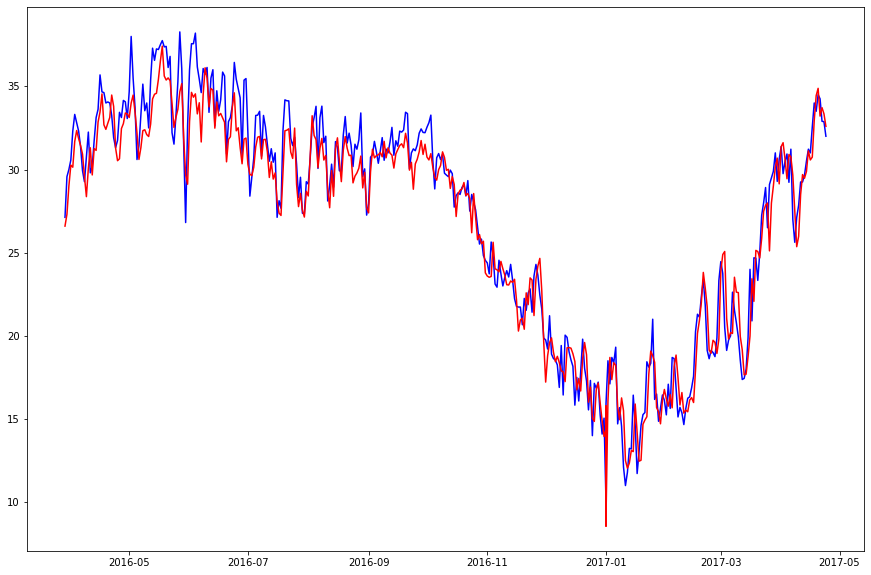

In [ ]:
# plot dataset
# plot
plt.figure(figsize=(15,10))  
plt.plot(test['meantemp'], color='blue')
plt.plot(test['y_pred'], color='red')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Line(
    x=test.index,
    y=test['meantemp'],
    name="True values"       # this sets its legend entry
))


fig.add_trace(go.Line(
    x=test.index,
    y=test['y_pred'],
    name="Predicted values"
))

fig.update_layout(title='Random Forest predictions',
           xaxis_title='date',
           yaxis_title='Mean temperature',
           )


fig.show()

## Experimenting with even smaller sized training sets

In [ ]:
# fit model
tsmodel = TimeSeriesForestRegressor(n_estimators=100, min_interval=3)
tsmodel.fit(train_x, train_y)
y_pred_train = tsmodel.predict(train_x)

mae_train = metrics.mean_absolute_error(train_y, y_pred_train)
mse_train = metrics.mean_squared_error(train_y, y_pred_train)
rmse_train = np.sqrt(metrics.mean_squared_error(train_y, y_pred_train))

print('MAE train is: ', mae_train)
print('MSE train is: ', mse_train)
print('RMSE train is: ', rmse_train)

MAE train is:  6.571919169794666e-15
MSE train is:  2.3834277657880596e-28
RMSE train is:  1.543835407609263e-14
